In [ ]:

from google.colab import drive

# # Load dataset

# data_path = "/content/drive/MyDrive/minor/carla_data_all_upto23/rollout_6.npz"
# data = np.load(data_path, allow_pickle=True)

import os
import glob
import numpy as np
drive.mount('/content/drive')


directories = [
    "/content/drive/MyDrive/minor/carla_data_all_upto23",
    "/content/drive/MyDrive/minor/carla_data_all_session2",
    "/content/drive/MyDrive/minor/carla_data_all"
]


Mounted at /content/drive


In [ ]:
states = []
action1 = []

for folder in directories:
    files = glob.glob(os.path.join(folder, "*.npz"))
    for file_path in files:
        data = np.load(file_path, allow_pickle=True)
        observations = data["observations"]
        actions = data["actions"]

        # Use N = min(n, m) where n = #observations, m = #actions
        N = min(len(observations), len(actions))

        for i in range(N):
            comp_img = observations[i]

            if isinstance(comp_img, np.ndarray) and comp_img.ndim == 0:
                comp_img = comp_img.item()

            states.append(comp_img)
            action1.append(actions[i])

all_images_array = np.array(states, dtype=object)
all_actions_array = np.array(action1)

print("Total images collected:", all_images_array.shape[0])
print("Total actions collected:", all_actions_array.shape[0])

Total images collected: 39071
Total actions collected: 39071


In [ ]:
num_actions = len(action1)
action = np.zeros((num_actions, 3))
for i in range(num_actions):
    action_dict = all_actions_array[i]
    action[i, 0] = action_dict['throttle']
    action[i, 1] = action_dict['steer']
    action[i, 2] = action_dict['brake']

[0.85000002 0.00181345 0.        ]


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import io

In [ ]:
class CarlaImageDataset(Dataset):
    def __init__(self, encoded_images, actions):
        self.encoded_images = encoded_images
        self.actions = actions

    def __len__(self):
        return len(self.encoded_images)

    def __getitem__(self, idx):

        encoded_img = self.encoded_images[idx]


        img = Image.open(io.BytesIO(encoded_img))
        img_array = np.array(img)
        img_array = img_array / 255.0
        img_tensor = torch.from_numpy(img_array).unsqueeze(0).float()
        return img_tensor, self.actions[idx]

# Create dataset and dataloader
dataset = CarlaImageDataset(all_images_array, all_actions_array)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

latent_dim = 64

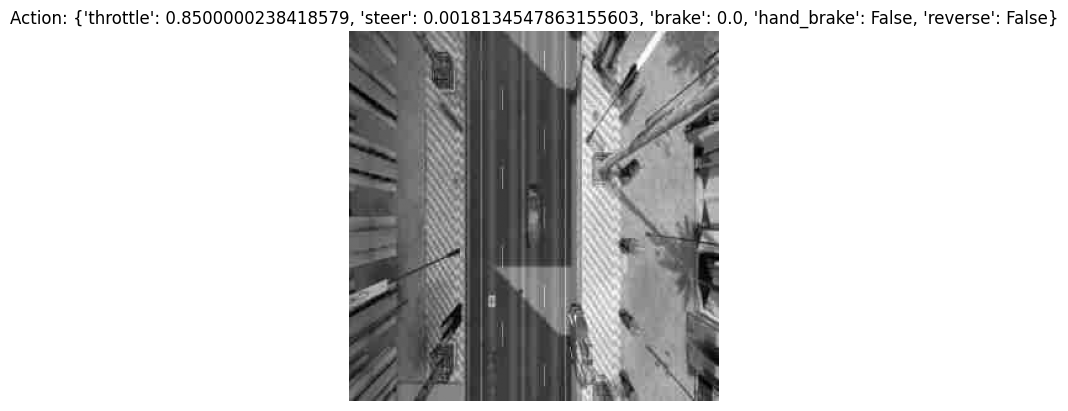

In [ ]:
# import matplotlib.pyplot as plt

# # Get a sample image and its corresponding action from the dataset
# img_tensor, action_val = dataset[0]

# # Squeeze to remove the channel dimension and convert to numpy array
# img_np = img_tensor.squeeze().numpy()

# plt.imshow(img_np, cmap='gray')
# plt.title(f"Action: {action_val}")
# plt.axis('off')
# plt.show()

In [ ]:
# Create dataset and dataloader
dataset = CarlaImageDataset(all_images_array, all_actions_array)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Define VAE architecture for 300x300 images with latent dimension 64
latent_dim = 64

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),    # -> [32, 150, 150]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # -> [64, 75, 75]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> [128, 38, 38]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # -> [256, 19, 19]
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # -> [512, 10, 10]
            nn.ReLU()
        )


        self.flatten_size = 41472

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)


        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> [256, 19, 19]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> [128, 38, 38]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # -> [64, 75, 75]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # -> [32, 150, 150]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=16, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)     # sample from N(0,1)
        return mu + std * eps           # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 512, 9, 9)  # Reshape to match encoder output
        x = self.decoder(x)
        return x


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [ ]:

# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Return both individual losses and total loss
    return BCE, KLD, BCE + KLD

# Tracking losses for plotting
epoch_train_losses = []
epoch_bce_losses = []
epoch_kld_losses = []

# Training loop
epochs = 50
model.train()

for epoch in range(1, epochs + 1):
    train_loss = 0
    bce_loss = 0
    kld_loss = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)


        batch_bce, batch_kld, loss = loss_function(recon_batch, data, mu, logvar)


        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        bce_loss += batch_bce.item()
        kld_loss += batch_kld.item()


        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataset)} '
                  f'({100. * batch_idx / len(dataloader):.0f}%)]\t'
                  f'Loss: {loss.item() / len(data):.6f}')


    avg_loss = train_loss / len(dataset)
    avg_bce = bce_loss / len(dataset)
    avg_kld = kld_loss / len(dataset)


    epoch_train_losses.append(avg_loss)
    epoch_bce_losses.append(avg_bce)
    epoch_kld_losses.append(avg_kld)

    print(f'       Epoch: {epoch} Average loss: {avg_loss:.6f}')
    print(f'       BCE Loss: {avg_bce:.6f}, KLD Loss: {avg_kld:.6f}')


    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():

            test_data, _ = next(iter(dataloader))
            test_data = test_data.to(device)


            recon, _, _ = model(test_data)


            n = min(5, batch_size)


            fig, axs = plt.subplots(2, n, figsize=(15, 6))

            for i in range(n):
                # original
                axs[0, i].imshow(test_data[i].cpu().squeeze().numpy(), cmap='gray')
                axs[0, i].set_title('Original')
                axs[0, i].axis('off')

                # reconstruction
                axs[1, i].imshow(recon[i].cpu().squeeze().numpy(), cmap='gray')
                axs[1, i].set_title('Reconstructed')
                axs[1, i].axis('off')

            plt.savefig(f'/content/drive/MyDrive/vae_reconstructions_epoch_{epoch}.png')
            torch.save(model.state_dict(), f'/content/drive/MyDrive/vae_model_epoch_{epoch}.pth')
            plt.close()

        model.train()


Epoch: 1 [0/39071 (0%)]	Loss: 56871.261719
Epoch: 1 [640/39071 (2%)]	Loss: 57022.105469
Epoch: 1 [1280/39071 (3%)]	Loss: 56811.812500
Epoch: 1 [1920/39071 (5%)]	Loss: 56414.882812
Epoch: 1 [2560/39071 (7%)]	Loss: 57137.847656
Epoch: 1 [3200/39071 (8%)]	Loss: 56718.121094
Epoch: 1 [3840/39071 (10%)]	Loss: 56476.246094
Epoch: 1 [4480/39071 (11%)]	Loss: 56780.128906
Epoch: 1 [5120/39071 (13%)]	Loss: 56354.523438
Epoch: 1 [5760/39071 (15%)]	Loss: 56728.718750
Epoch: 1 [6400/39071 (16%)]	Loss: 56441.679688
Epoch: 1 [7040/39071 (18%)]	Loss: 57072.695312
Epoch: 1 [7680/39071 (20%)]	Loss: 56478.242188
Epoch: 1 [8320/39071 (21%)]	Loss: 56069.015625
Epoch: 1 [8960/39071 (23%)]	Loss: 56981.468750
Epoch: 1 [9600/39071 (25%)]	Loss: 57106.664062
Epoch: 1 [10240/39071 (26%)]	Loss: 57195.644531
Epoch: 1 [10880/39071 (28%)]	Loss: 56834.089844
Epoch: 1 [11520/39071 (29%)]	Loss: 56463.218750
Epoch: 1 [12160/39071 (31%)]	Loss: 56730.042969
Epoch: 1 [12800/39071 (33%)]	Loss: 56208.488281
Epoch: 1 [13440/39

KeyboardInterrupt: 

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/vae_carla_model2.pth')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Plot training losses
plt.figure(figsize=(12, 8))



print("Epochs:", epochs)
print("Shape of epoch_train_losses:", len(epoch_train_losses))
print("Shape of epoch_bce_losses:", len(epoch_bce_losses))
print("Shape of epoch_kld_losses:", len(epoch_kld_losses))


# Plot total loss
plt.subplot(3, 1, 1)
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, 'b-')
plt.title('Total VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot BCE loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_bce_losses, 'r-')
plt.title('Reconstruction Loss (BCE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot KLD loss
plt.subplot(3, 1, 3)
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_kld_losses, 'g-')
plt.title('KL Divergence Loss (KLD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/vae_training_losses5.png')
plt.close()


Epochs: 50
Shape of epoch_train_losses: 21
Shape of epoch_bce_losses: 21
Shape of epoch_kld_losses: 21


In [ ]:
# Generate samples from latent space for visualization
model.eval()
with torch.no_grad():
    # Sample from latent space
    sample = torch.randn(10, latent_dim).to(device)
    sample = model.decode(sample).cpu()

    # Display generated samples
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(sample[i].squeeze().numpy(), cmap='gray')
        plt.title(f'Sample {i+1}')
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/vae_latent_samples.png')
    plt.close()


In [ ]:

def visualize_latent_space(model, dataloader, device, num_batches=5):
    model.eval()
    all_mu = []
    all_actions = []

    with torch.no_grad():
        for i, (data, actions) in enumerate(dataloader):
            if i >= num_batches:
                break

            data = data.to(device)
            mu, _ = model.encode(data)
            all_mu.append(mu.cpu().numpy())
            all_actions.append(actions.numpy())


    all_mu = np.concatenate(all_mu, axis=0)
    all_actions = np.concatenate(all_actions, axis=0)


    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    mu_2d = pca.fit_transform(all_mu)

    plt.figure(figsize=(10, 8))
    plt.scatter(mu_2d[:, 0], mu_2d[:, 1], c=all_actions[:, 0], cmap='viridis', alpha=0.6)
    plt.colorbar(label='Steering Action')
    plt.title('2D PCA Projection of Latent Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/vae_latent_space.png')
    plt.close()


visualize_latent_space(model, dataloader, device)

print("All visualizations saved!")

AttributeError: 'dict' object has no attribute 'numpy'

Type of observations: <class 'numpy.ndarray'>
Length of observations: 623
Type of first element: <class 'numpy.ndarray'>
Total images collected: 623
Total actions collected: 624
Compressed image type: <class 'numpy.ndarray'>
Decoded image shape: (300, 300, 3)
Action: {'throttle': 0.0, 'steer': -0.1158556118607521, 'brake': 0.699999988079071, 'hand_brake': False, 'reverse': False}


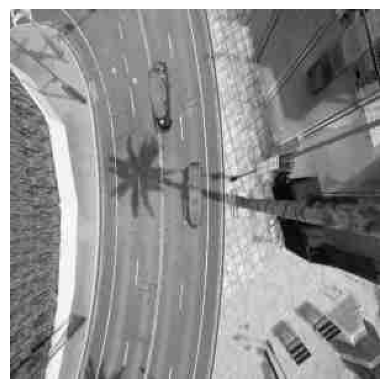

In [ ]:
# # Debug the structure of observations
# observations = data["observations"]
# actions = data["actions"]
# print("Type of observations:", type(observations))
# print("Length of observations:", len(observations))
# print("Type of first element:", type(observations[0]))

# # Use the observations directly if they're already the correct structure
# all_images = observations
# all_actions = actions

# print(f"Total images collected: {len(all_images)}")
# print(f"Total actions collected: {len(all_actions)}")

# # Choose an index to visualize (e.g., index 4)
# idx = 200
# if idx < len(all_images):
#     compressed_img = all_images[idx]

#     # If it's stored as a 0-d array, extract the actual data
#     if isinstance(compressed_img, np.ndarray) and compressed_img.ndim == 0:
#         compressed_img = compressed_img.item()

#     print("Compressed image type:", type(compressed_img))

#     # Decode the JPEG image data back to a BGR image
#     img_decoded = cv2.imdecode(compressed_img, cv2.IMREAD_COLOR)
#     if img_decoded is None:
#         print("Image decoding failed.")
#     else:
#         # Convert BGR to RGB for displaying with matplotlib
#         img_rgb = cv2.cvtColor(img_decoded, cv2.COLOR_BGR2RGB)
#         print("Decoded image shape:", img_rgb.shape)

#         # Get corresponding action for display
#         action = all_actions[idx]
#         print("Action:", action)

#         # Display the image
#         plt.imshow(img_rgb)
#         plt.axis("off")
#         plt.show()
# else:
#     print(f"Index {idx} out of range. Only {len(all_images)} images available.")

In [ ]:
  # # Create a video visualization of an episode
# from IPython.display import HTML
# from base64 import b64encode
# import io
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# def create_episode_video(episode, episode_idx=0, sample_rate=5):
#     """Create a video from episode frames, sampling every sample_rate frames"""
#     fps = 10
#     frames = []

#     for step_idx in range(0, len(episode), sample_rate):
#         # Get frame and data
#         frame = episode[step_idx]['observation']
#         velocity = episode[step_idx]['speed']
#         throttle = episode[step_idx]['action']['throttle']
#         brake = episode[step_idx]['action']['brake']
#         steer = episode[step_idx]['action']['steer']

#         # Create figure with frame and info
#         fig = plt.figure(figsize=(8, 8), dpi=72)
#         plt.imshow(frame, cmap='gray')
#         plt.title(f"Episode {episode_idx+1}, Step {step_idx}")
#         plt.xlabel(f"Speed: {velocity:.2f}, Throttle: {throttle:.2f}, Brake: {brake:.2f}, Steer: {steer:.2f}")
#         plt.axis('on')

#         # Convert figure to image
#         canvas = FigureCanvas(fig)
#         canvas.draw()
#         buf = io.BytesIO()
#         plt.savefig(buf, format='png')
#         plt.close(fig)
#         buf.seek(0)
#         img = plt.imread(buf)
#         frames.append(img)

#     # Create video
#     height, width, _ = frames[0].shape
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     video_path = f"/tmp/episode_{episode_idx+1}.mp4"
#     video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

#     for frame in frames:
#         # Convert RGB to BGR for OpenCV
#         frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#         video.write((frame_bgr * 255).astype(np.uint8))

#     video.release()

#     # Display video in notebook
#     mp4 = open(video_path, 'rb').read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
#     return HTML(f'<video width=600 controls><source src="{data_url}" type="video/mp4"></video>')

# # Create and display a video of the first episode
# selected_episode = 0
# video = create_episode_video(rollouts[selected_episode], selected_episode)
# display(video)

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pickle
from google.colab import drive
import cv2


drive.mount('/content/drive')


class StreamingCarRacingDataset(Dataset):
    def __init__(self, data_path):

        with open(data_path, "rb") as f:
            self.rollouts = pickle.load(f)

        self.episode_map = []
        for ep_idx, episode in enumerate(self.rollouts):
            for state_idx in range(len(episode)):
                self.episode_map.append((ep_idx, state_idx))

        print(f"Dataset contains {len(self.episode_map)} total states")

    def __len__(self):
        return len(self.episode_map)

    def __getitem__(self, idx):
        ep_idx, state_idx = self.episode_map[idx]
        obs, _, _, _, _ = self.rollouts[ep_idx][state_idx]

        obs = np.expand_dims(obs, axis=0)
        return torch.tensor(obs, dtype=torch.float32)


data_path = "/content/drive/MyDrive/data/car_racing_rollouts_6.pkl"


dataset = StreamingCarRacingDataset(data_path)

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

latent_dim = 32

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# -> [256, 4, 4]
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)


        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> [1, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample from N(0,1)
        return mu + std * eps          # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def loss_function(recon_x, x, mu, logvar):
    # Binary Cross Entropy loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


import os


checkpoint_dir = "/content/drive/MyDrive/vae_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

epochs = 150
model.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    num_batches = 0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        num_batches += 1


        if num_batches % 50 == 0:
            print(f"Epoch {epoch}, Batch {num_batches}/{len(dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = train_loss / len(dataset)
    print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

    if epoch % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset contains 266870 total states
Epoch 1, Batch 50/2085, Loss: 312420.9688
Epoch 1, Batch 100/2085, Loss: 307007.0000
Epoch 1, Batch 150/2085, Loss: 306887.4688
Epoch 1, Batch 200/2085, Loss: 303911.5938
Epoch 1, Batch 250/2085, Loss: 303611.7188
Epoch 1, Batch 300/2085, Loss: 302928.2188
Epoch 1, Batch 350/2085, Loss: 303468.4062


KeyboardInterrupt: 

In [ ]:

final_model_path = os.path.join(checkpoint_dir, "vae_final.pt")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")


def visualize_reconstructions(model, dataset, num_examples=10):
    model.eval()

    viz_dir = "/content/drive/MyDrive/vae_visualizations"
    os.makedirs(viz_dir, exist_ok=True)
    indices = np.random.choice(len(dataset), num_examples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):

            original = dataset[idx].unsqueeze(0).to(device)
            recon, _, _ = model(original)
            original_np = original.cpu().squeeze().numpy()
            recon_np = recon.cpu().squeeze().numpy()
            comparison = np.hstack((original_np, recon_np))
            cv2.imwrite(os.path.join(viz_dir, f"reconstruction_{i}.png"), comparison * 255)

    print(f"Visualizations saved to {viz_dir}")

visualize_reconstructions(model, dataset)

Final model saved to /content/drive/MyDrive/vae_checkpoints/vae_final.pt
Visualizations saved to /content/drive/MyDrive/vae_visualizations


In [ ]:

states = []
for episode in rollouts:
    for transition in episode:
        obs, action, reward, next_obs, done = transition
        states.append(obs)
states = np.array(states)  # shape: (N, 64, 64)
states = states[:, np.newaxis, :, :]  # dim: (N, 1, 64, 64)
print("Total states:", states.shape[0])

class CarRacingDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

dataset = CarRacingDataset(states)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

latent_dim = 32


Total states: 266870


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# -> [256, 4, 4]
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)


        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> [1, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample from N(0,1)
        return mu + std * eps          # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    # Binary Cross Entropy loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
epochs = 150
model.train()
loss = []
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(dataset)
    print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")


In [ ]:
# Save the trained model to Google Drive
torch.save(model.state_dict(), "/content/drive/MyDrive/vae_car_racing_better.pth")
print("Model saved!")

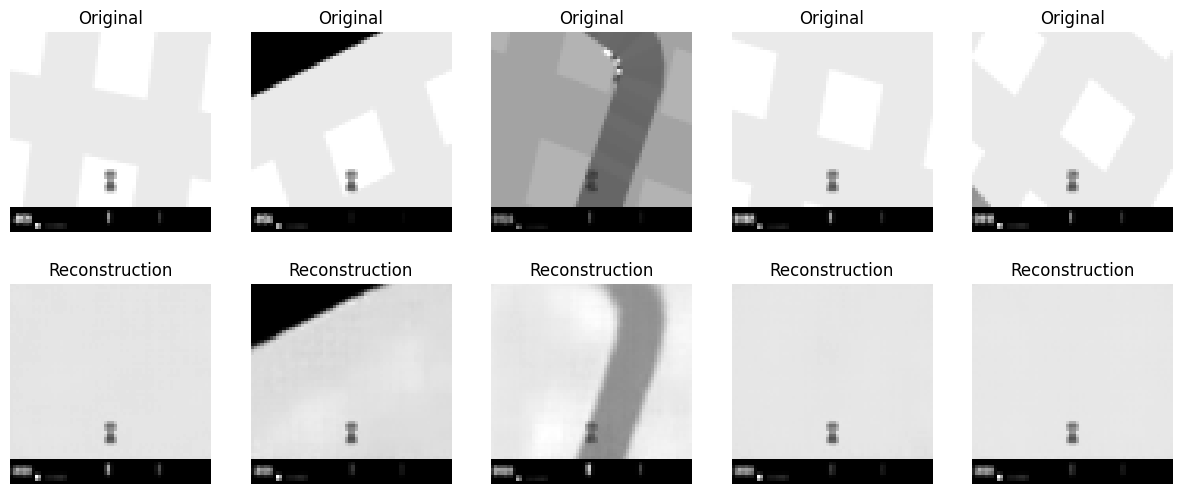

In [ ]:
import matplotlib.pyplot as plt


model.eval()
with torch.no_grad():
    sample = next(iter(dataloader)).to(device)
    recon, _, _ = model(sample)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(sample[i].cpu().squeeze(), cmap='gray')
    axs[0, i].set_title("Original")
    axs[0, i].axis('off')

    axs[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
    axs[1, i].set_title("Reconstruction")
    axs[1, i].axis('off')
plt.show()
